In [1]:
import pandas as pd
import numpy as np
import requests
import datetime
import time
import math

import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import xgboost as xgb

In [2]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LSTM
from keras.layers import Dropout

/Users/William/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
bdata = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20150101&end="+time.strftime("%Y%m%d"))[0]

In [25]:
bdata = bdata.assign(Date=pd.to_datetime(bdata['Date']))
bdata['Volume'] = bdata['Volume'].astype('int64')

In [43]:
bdata.iloc[0]['Close']

9119.01

In [26]:
bdata.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-05-01,9251.47,9255.88,8891.05,9119.01,7713020000,157350000000
1,2018-04-30,9426.11,9477.14,9166.81,9240.55,8673920000,160302000000
2,2018-04-29,9346.41,9531.49,9193.71,9419.08,8853000000,158928000000
3,2018-04-28,8939.27,9412.09,8931.99,9348.48,7805480000,151991000000
4,2018-04-27,9290.63,9375.47,8987.05,8987.05,7566290000,157948000000


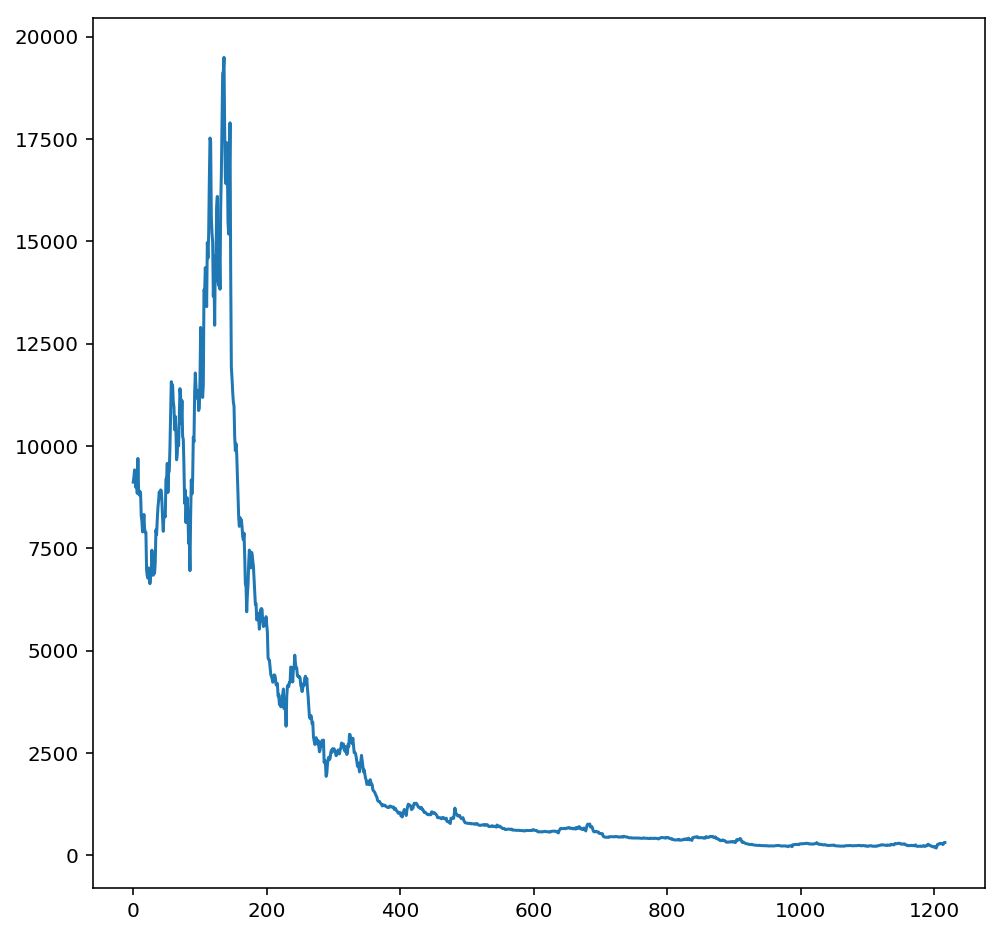

In [27]:
bdata['Close'].plot(figsize=(8,8))

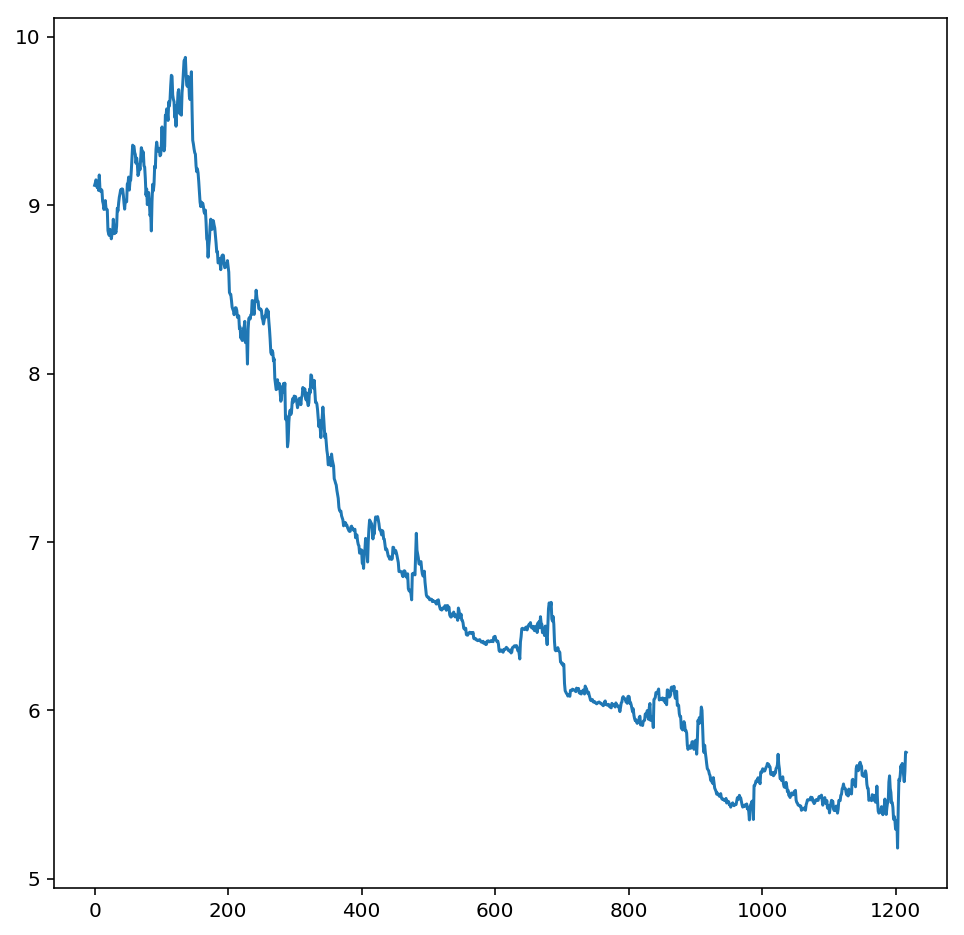

In [28]:
bdata['Natural Log'] = bdata['Close'].apply(lambda x: np.log(x))
bdata['Natural Log'].plot(figsize=(8,8))

In [29]:
bdata['LagFive'] = bdata['Close'].shift(5)
bdata['ForwardFive'] = bdata['Close'].shift(-5)
bdata[['Date','Close', 'ForwardFive', 'LagFive']].head(10)

,Date,Close,ForwardFive,LagFive
0,2018-05-01,9119.01,9281.51,NaN
1,2018-04-30,9240.55,8845.74,NaN
2,2018-04-29,9419.08,9697.50,NaN
3,2018-04-28,9348.48,8930.88,NaN
4,2018-04-27,8987.05,8802.46,NaN
5,2018-04-26,9281.51,8895.58,9119.01
6,2018-04-25,8845.74,8845.83,9240.55
7,2018-04-24,9697.50,8294.31,9419.08
8,2018-04-23,8930.88,8163.42,9348.48
9,2018-04-22,8802.46,7902.09,8987.05


In [30]:
# Calculate Exponential Moving Average
def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a =  np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a

ema = ExpMovingAverage(list(reversed(bdata['Close'])), 5) # window of 5

# Calculate Momentum / Rate of Change
roc = []
for i,j in zip(bdata['Close'], bdata['LagFive']):
    roc.append( (i / j) * 100 )
        
kwargs = {
            'Close Off High': lambda x: 2*(x['High'] - x['Close'])/(x['High'] - x['Low'])-1,
            'Volatility': lambda x: (x['High'] - x['Low'])/(x['Open']),
         }

bdata = bdata.assign(**kwargs)

# Get only relevant columns
mdata = bdata[['Date', 'Close', 'Volume', 'Close Off High', 'Volatility', 'ForwardFive']]
mdata = mdata.sort_values(by='Date')
mdata['EMA'] = ema
mdata['Momentum'] = roc
mdata['Next'] = mdata['Close'].shift(-1)
mdata.head(7)

,Date,Close,Volume,Close Off High,Volatility,ForwardFive,EMA,Momentum,Next
1216,2015-01-01,314.25,8036550,0.922360,0.020097,NaN,288.044092,NaN,315.03
1215,2015-01-02,315.03,7860650,-0.289474,0.007259,NaN,288.044092,NaN,281.08
1214,2015-01-03,281.08,33054400,1.000000,0.108210,NaN,288.044092,NaN,264.19
1213,2015-01-04,264.19,55629100,0.555706,0.105353,NaN,288.044092,NaN,274.47
1212,2015-01-05,274.47,43962800,-0.416290,0.050023,NaN,288.044092,NaN,286.19
1211,2015-01-06,286.19,23245700,-0.816835,0.054077,314.25,288.044092,101.781992,294.34
1210,2015-01-07,294.34,24866800,-0.437141,0.054775,315.03,278.019699,95.727419,283.35


In [31]:
mdata.tail(7)

,Date,Close,Volume,Close Off High,Volatility,ForwardFive,EMA,Momentum,Next
6,2018-04-25,8845.74,11083100000,0.902906,0.097462,8845.83,8991.486449,109.910381,9281.51
5,2018-04-26,9281.51,8970560000,-1.000000,0.062524,8895.58,9062.741914,107.727923,8987.05
4,2018-04-27,8987.05,7566290000,1.000000,0.041808,8802.46,9157.721216,99.879913,9348.48
3,2018-04-28,9348.48,7805480000,-0.735014,0.053707,8930.88,9269.777469,90.971385,9419.08
2,2018-04-29,9419.08,8853000000,-0.334419,0.036140,9697.50,9116.539397,99.198871,9240.55
1,2018-04-30,9240.55,8673920000,0.524764,0.032922,8845.74,9238.481675,107.029286,9119.01
0,2018-05-01,9119.01,7713020000,-0.249678,0.039435,9281.51,9207.727294,109.804675,NaN


In [32]:
# chop off first five rows which have NaN for Momentum and SMA values for EMA and last row which has no Next value
mdata = mdata.drop([1216, 1215, 1214, 1213, 1212, 0])
mdata = mdata.drop(['Date', 'Close'], axis=1)
mdata.head()

,Volume,Close Off High,Volatility,ForwardFive,EMA,Momentum,Next
1211,23245700,-0.816835,0.054077,314.25,288.044092,101.781992,294.34
1210,24866800,-0.437141,0.054775,315.03,278.019699,95.727419,283.35
1209,19982500,0.804184,0.040628,281.08,277.409391,102.955915,290.41
1208,18718600,-0.867675,0.037467,264.19,284.154444,95.532964,274.80
1207,15264300,0.882768,0.049286,274.47,286.942708,97.946045,265.66


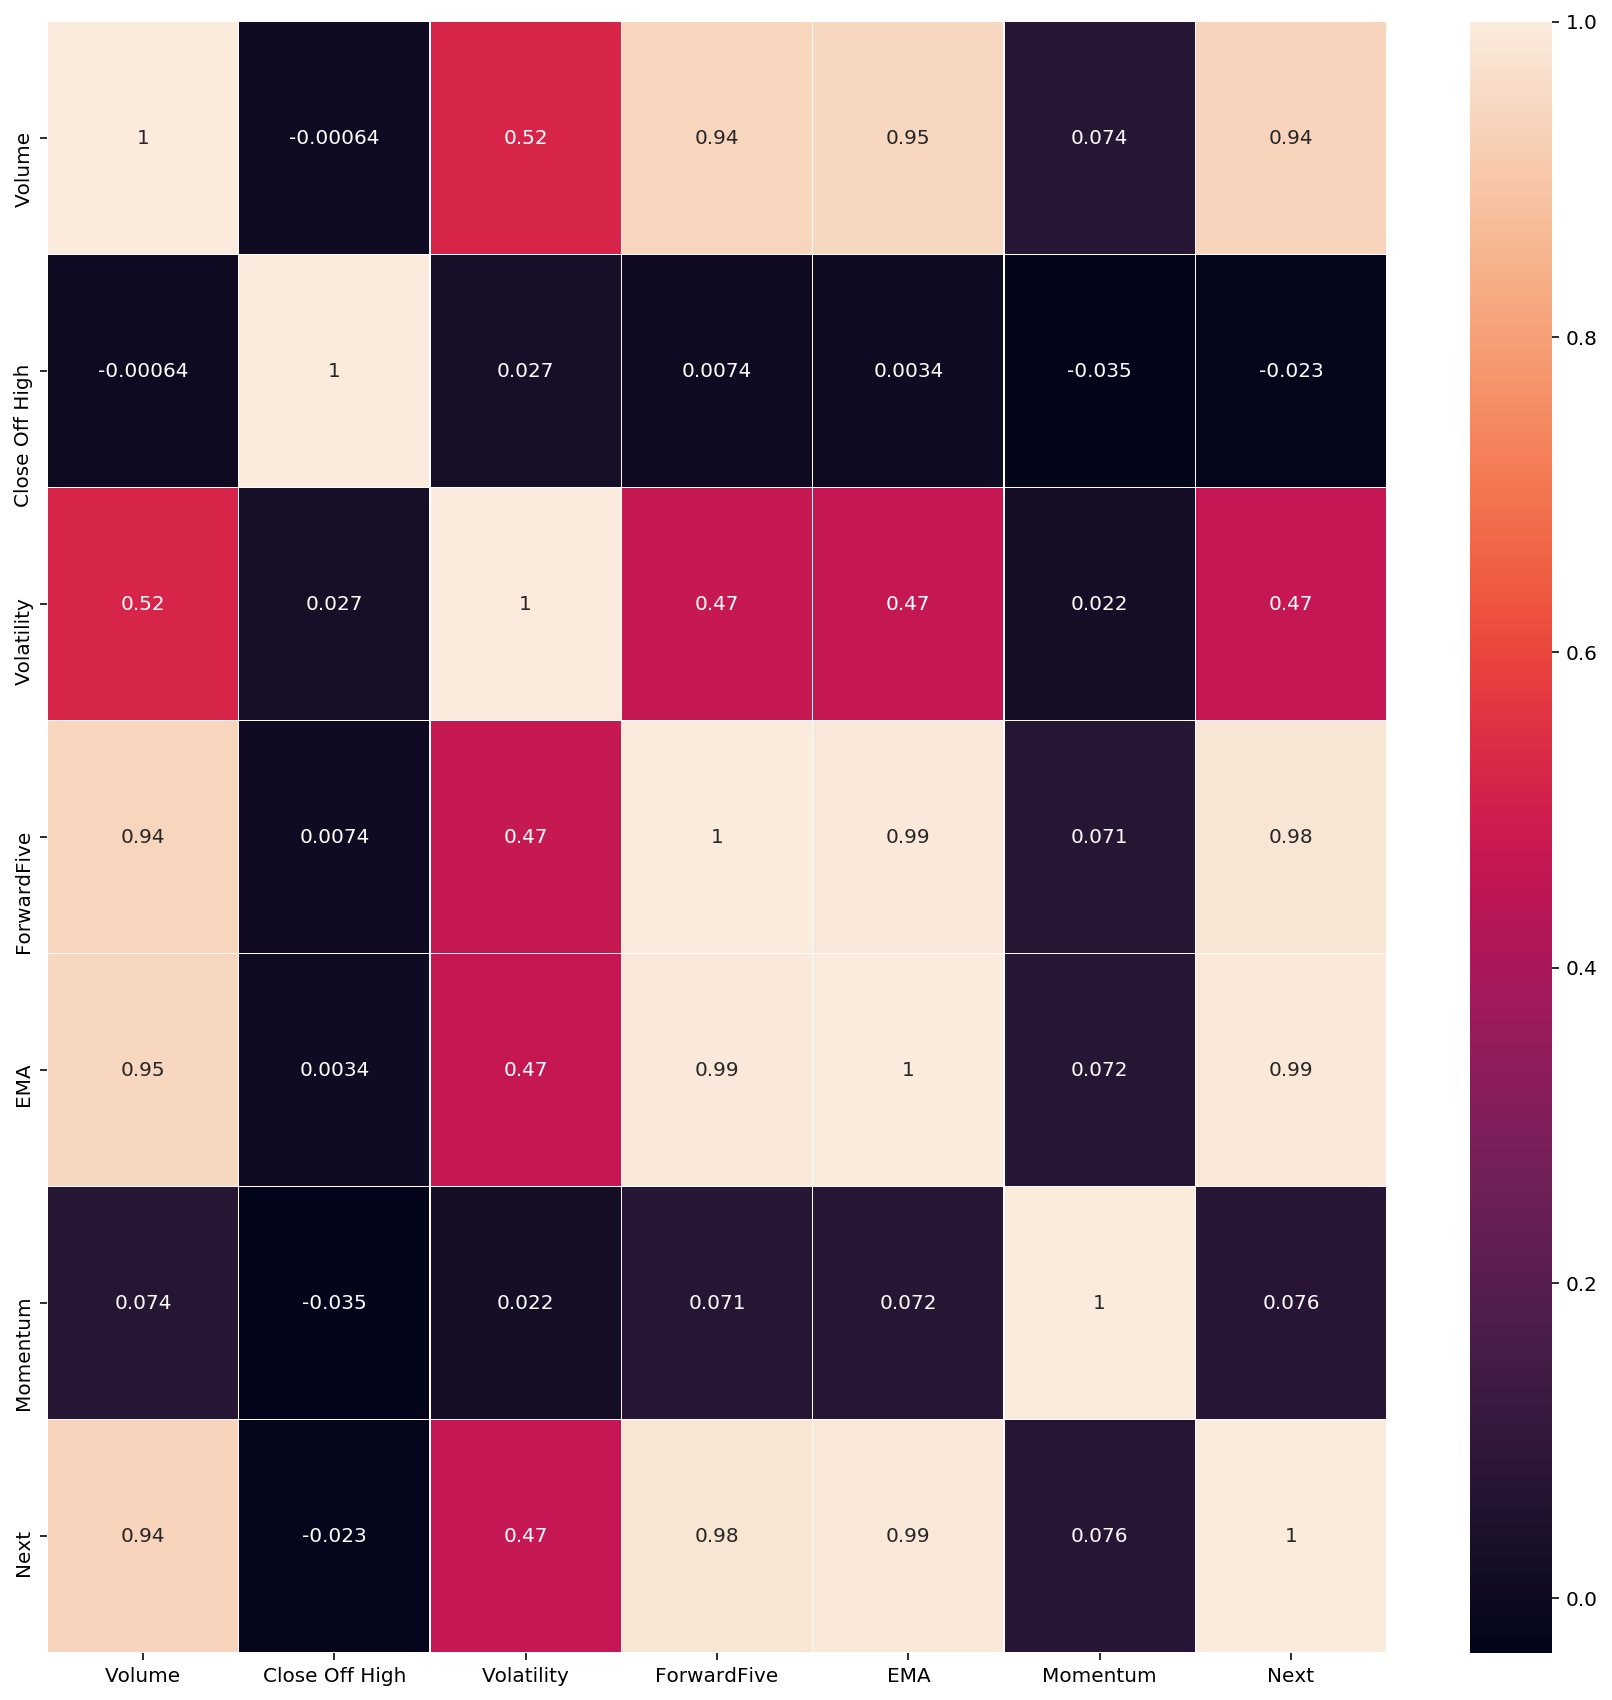

In [33]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(mdata.corr(), annot=True, linewidths=0.1, linecolor='white', cbar=True)

In [34]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_correlations(df, n=5):
    final_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    final_corr = final_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return final_corr[0:n]

get_top_correlations(mdata, 20)

ForwardFive     EMA            0.994373
EMA             Next           0.991359
ForwardFive     Next           0.980984
Volume          EMA            0.946559
                ForwardFive    0.940933
                Next           0.937071
                Volatility     0.521957
Volatility      ForwardFive    0.471453
                EMA            0.470519
                Next           0.465000
Momentum        Next           0.075732
Volume          Momentum       0.074292
EMA             Momentum       0.072333
ForwardFive     Momentum       0.071429
Close Off High  Momentum       0.034506
                Volatility     0.027247
                Next           0.022773
Volatility      Momentum       0.022245
Close Off High  ForwardFive    0.007366
                EMA            0.003448
dtype: float64

In [35]:
feature_cols = ['Volume', 'Close Off High', 'Volatility', 'EMA', 'Momentum', 'ForwardFive']

X = mdata[feature_cols]
Y = mdata['Next']

## Random Forest

In [114]:
rfreg = RandomForestRegressor()
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 122)
rfreg.fit(X_train, Y_train)

Y_pred = rfreg.predict(X_test)

result = math.sqrt(mse(Y_pred, Y_test))
result

402.2532994735528

In [26]:
feature_range = list(range(1, len(feature_cols)+1))

RMSE_scores = []

for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, Y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

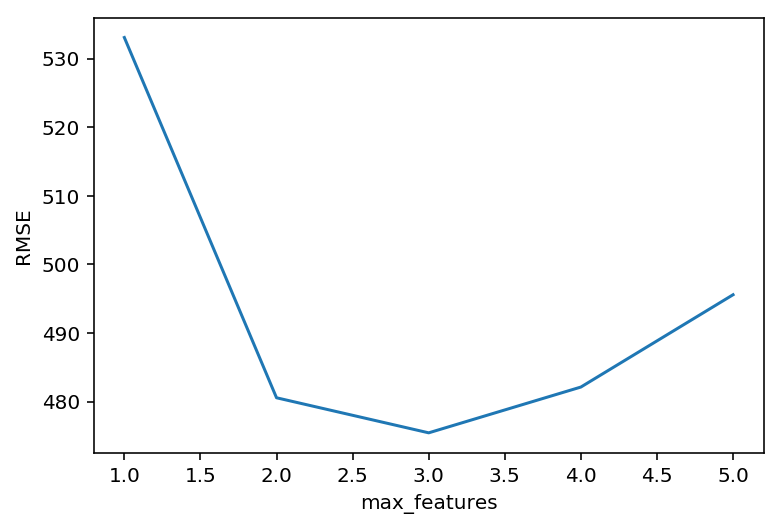

In [27]:
plt.plot(feature_range, RMSE_scores);

plt.xlabel('max_features');
plt.ylabel('RMSE');

In [28]:
sorted(zip(RMSE_scores, feature_range))[0]

(475.4670147805734, 3)

In [115]:
rfreg = RandomForestRegressor(n_estimators=30, max_features=3, oob_score=True, random_state=122)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 122)
rfreg.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=True, random_state=122,
           verbose=0, warm_start=False)

In [116]:
Y_pred = rfreg.predict(X_test)

result = math.sqrt(mse(Y_pred, Y_test))
result

424.39618465560505

In [117]:
rfreg = RandomForestRegressor(n_estimators=1000, max_features=5, oob_score=True, random_state=1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 122)
rfreg.fit(X_train, Y_train)

Y_pred = rfreg.predict(X_test)

result = math.sqrt(mse(Y_pred, Y_test))
result

404.01225217710754

In [20]:
 mdata.iloc[0].values.reshape(1, -1)

array([[ 2.32457000e+07, -8.16835017e-01,  5.40766906e-02,
         3.14250000e+02,  2.88044092e+02,  1.01781992e+02,
         2.94340000e+02]])

In [22]:
rfreg = RandomForestRegressor(n_estimators=1000, max_features=5, oob_score=True, random_state=1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 122)
rfreg.fit(X_train, Y_train)

print( rfreg.predict( X.iloc[-1].values.reshape(1, -1) ) )

[9548.44857]


In [129]:
 from random import randint

In [ ]:
test = pd.DataFrame()

for i in range(0,20):
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
    rf = RandomForestRegressor(n_estimators=randint(1000,2000), max_features=5, oob_score=True)
    rf.fit(X_train, Y_train)
    test[i] = rf.predict(X_train)

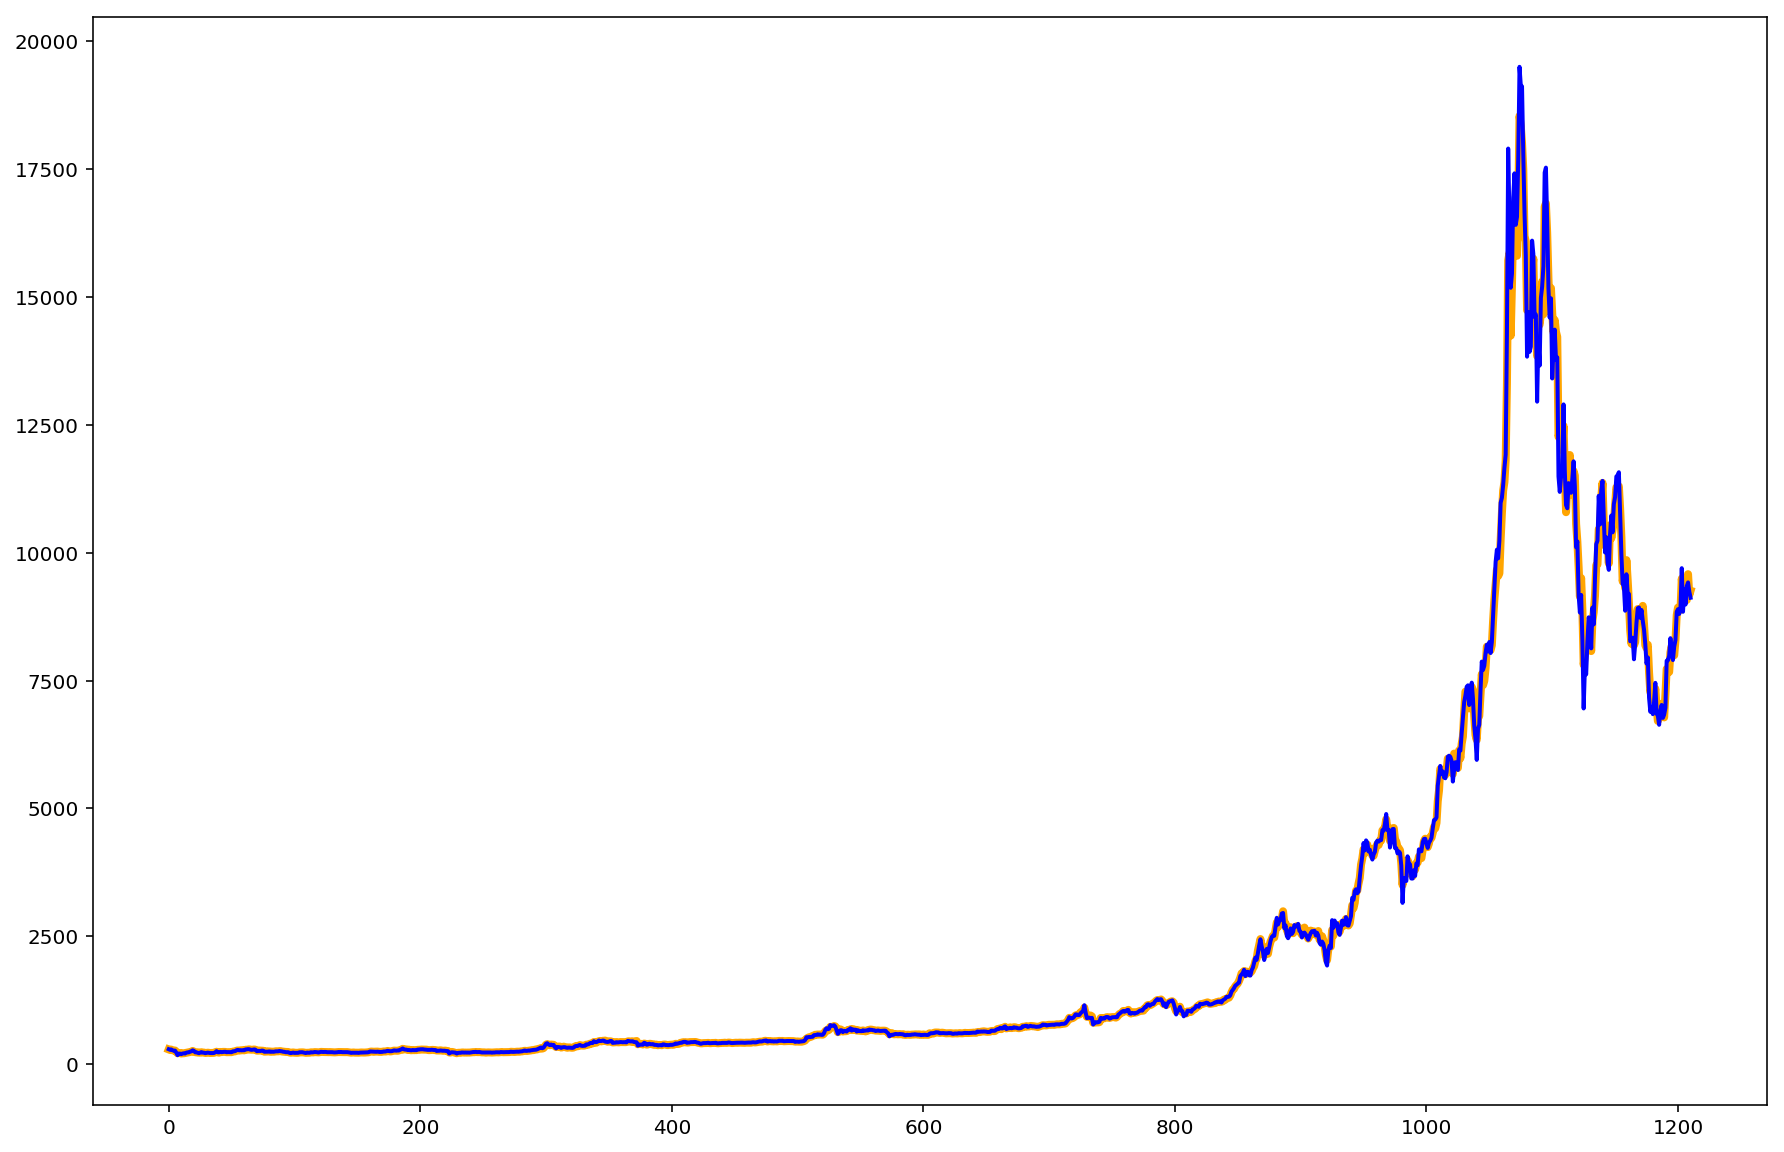

In [96]:
s = range(0,1211)
plt.figure(figsize=(15,10))
plt.plot( s, Y_prod, color='orange', linewidth=4)
plt.plot( s, Y, color='blue', linewidth=2)

## XGBoost

In [32]:
from sklearn.model_selection import KFold

In [33]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
clf.fit(X, Y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
-1.5252000104779138
{'max_depth': 6, 'n_estimators': 50}


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.8s finished


In [118]:
kf = KFold(n_splits=10, shuffle=True, random_state=9)

xg_pred = []

for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(
        max_depth=6,
        n_estimators=50
    ).fit(np.array(X)[train_index], np.array(Y)[train_index])
    predictions = xgb_model.predict(np.array(X)[test_index])
    actual =  np.array(Y)[test_index]
    xg_pred.append( math.sqrt(mse(actual, predictions)) )

print('XGBoost RMSE Average', np.mean(xg_pred))

XGBoost RMSE Average 489.8492150098861


In [119]:
kf = KFold(n_splits=10, shuffle=True, random_state=9)

xg_pred = []

for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(
    ).fit(np.array(X)[train_index], np.array(Y)[train_index])
    predictions = xgb_model.predict(np.array(X)[test_index])
    actual =  np.array(Y)[test_index]
    xg_pred.append( math.sqrt(mse(actual, predictions)) )

print('XGBoost RMSE Average', np.mean(xg_pred))

XGBoost RMSE Average 452.3993671154788


In [23]:
xgb_model = xgb.XGBRegressor().fit(np.array(X), np.array(Y))

print( xgb_model.predict( X.iloc[-1].values.reshape(1, -1)  ) )

[9341.043]


In [120]:
f= range(0,121)

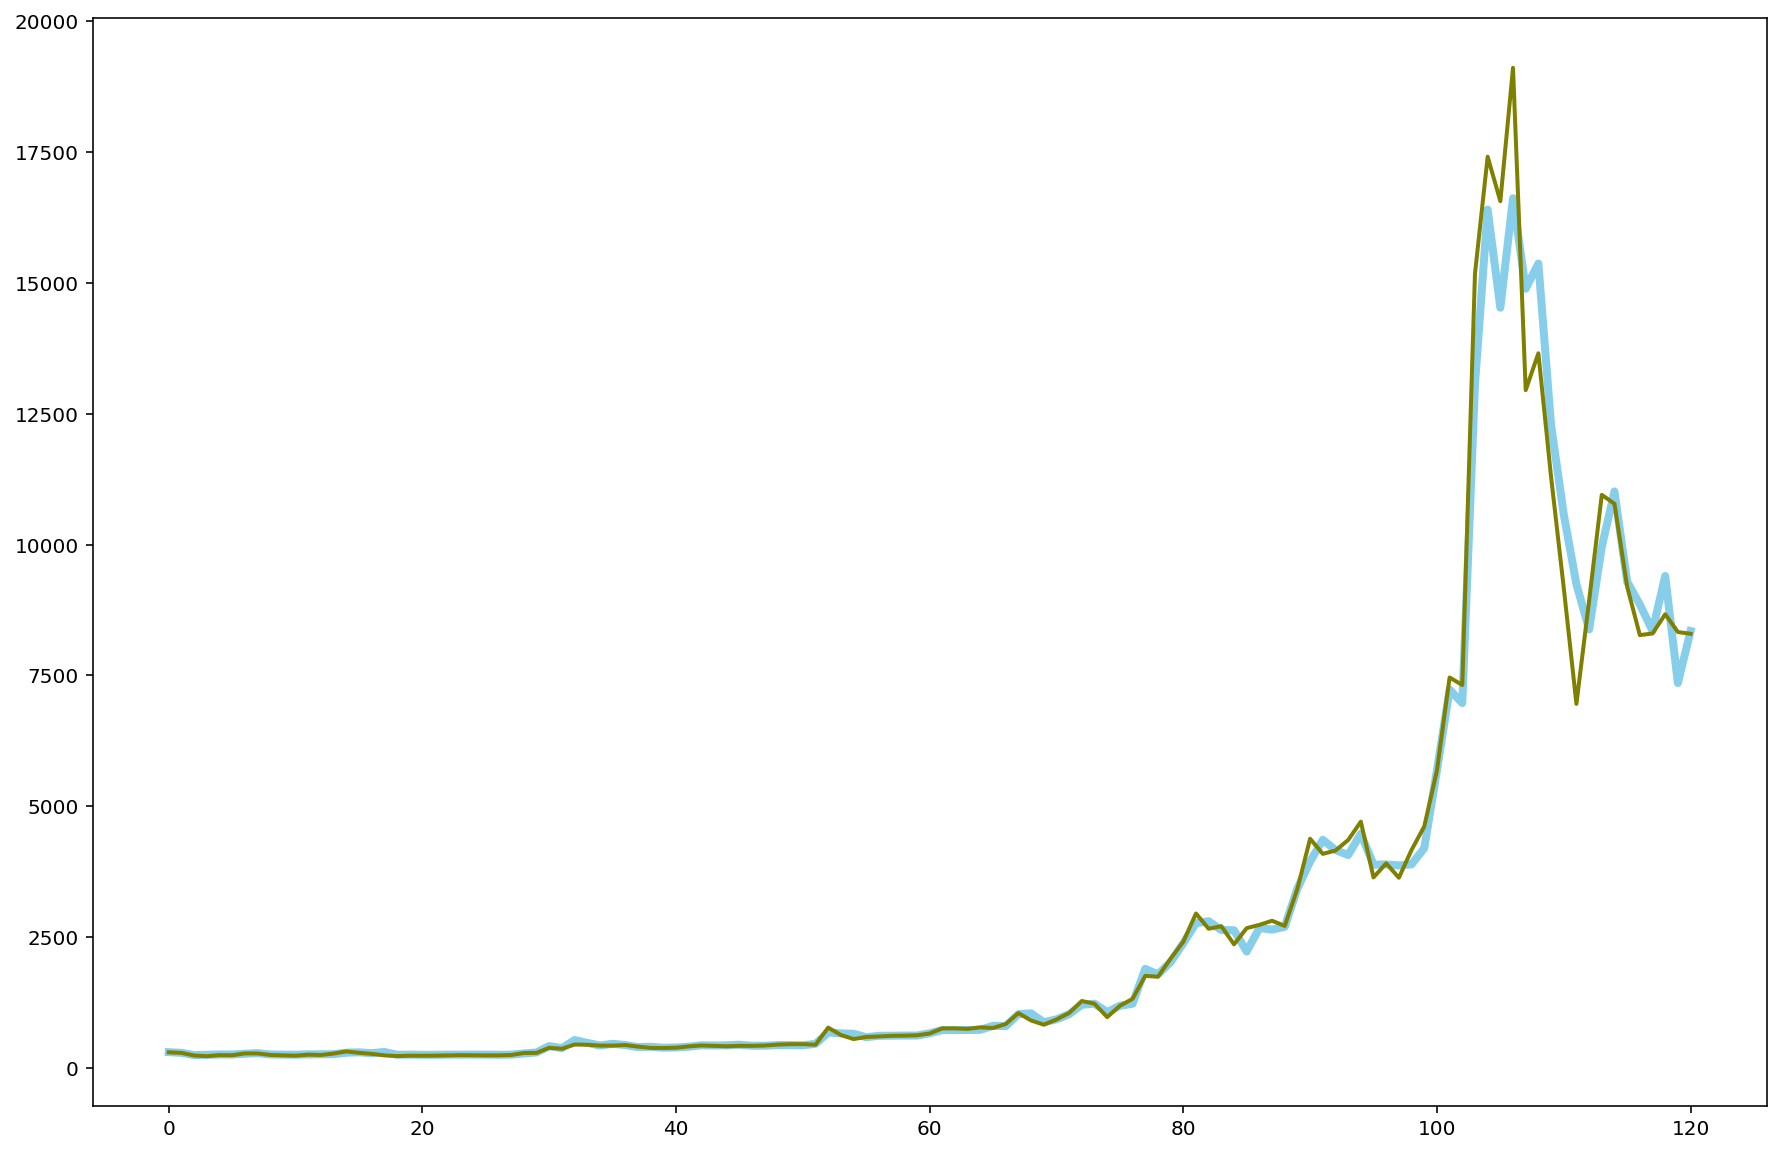

In [121]:
plt.figure(figsize=(15,10))
plt.plot( f, predictions, color='skyblue', linewidth=4)
plt.plot( f, actual, color='olive', linewidth=2)

## NN

In [ ]:
mdata = bdata[['Date']+['Close']+['Volume']+['Close Off High']+['Volatility']]
mdata = mdata.sort_values(by='Date')

In [ ]:
split_date = '2017-07-01'
training_set, test_set = mdata[mdata['Date']<split_date], mdata[mdata['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [ ]:
window_len=10
norm_cols= ['Close', 'Volume']

In [ ]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

In [ ]:
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

In [ ]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)

In [ ]:
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

In [ ]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [ ]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(69)
btc_model = build_model(LSTM_training_inputs, output_size=1, neurons=20)
btc_history = btc_model.fit(LSTM_training_inputs, LSTM_training_outputs, epochs=80, batch_size=128, verbose=1, shuffle=True)